In [1]:
import os
import gc
import math
import pickle
import numpy as np
import pandas as pd
import scipy.sparse as sps
import scanpy as sc
import anndata as ad
import scipy.io as sio

from os.path import join
import matplotlib.pyplot as plt

from sklearn.metrics import roc_auc_score
import gc

from sklearn.preprocessing import normalize
from sklearn.utils.extmath import randomized_svd

import sys
sys.path.insert(0, '../')
from src.ace import ACE
from src.utils import nn_approx

os.environ['CUDA_VISIBLE_DEVICES'] = '1'

## loading data

In [2]:
# Path to the data directory
data_dir = "../data/demo_data"

print('Reading `npz` files...')
rna_norm_mat = sps.csr_matrix(sps.load_npz(join(data_dir, 'rna_norm_mat.npz')))
adt_norm_mat = sps.csr_matrix(sps.load_npz(join(data_dir, 'adt_norm_mat.npz')))

rna_names = pd.read_csv(join(data_dir, 'gene_names.csv'))['x'].to_numpy()
adt_names = pd.read_csv(join(data_dir, 'adt_names.csv'))['x'].to_numpy()

cell_names = pd.read_csv(join(data_dir, 'cell_names.csv'))['x'].to_numpy()
meta_data = pd.read_csv(join(data_dir, 'metadata.csv'), index_col=0)
meta_data['batch'] = meta_data['donor'].to_numpy()

train_idx = np.where((meta_data.batch=='batch1').to_numpy())[0]
test_idx  = np.where((meta_data.batch=='batch2').to_numpy())[0]

print('Creating `h5ad` files...')
input_train_mod1 = sc.AnnData(sps.csr_matrix(rna_norm_mat[train_idx]), obs=meta_data.iloc[train_idx])
input_train_mod2 = sc.AnnData(sps.csr_matrix(adt_norm_mat[train_idx]), obs=meta_data.iloc[train_idx])
input_test_mod1 = sc.AnnData(sps.csr_matrix(rna_norm_mat[test_idx]), obs=meta_data.iloc[test_idx])
input_test_mod2 = sc.AnnData(sps.csr_matrix(adt_norm_mat[test_idx]), obs=meta_data.iloc[test_idx])

# set var names
input_train_mod1.var_names = input_test_mod1.var_names = rna_names
input_train_mod2.var_names = input_test_mod2.var_names = adt_names

# select hvg for evaluation
ad_rna = sc.AnnData(rna_norm_mat, obs=meta_data.loc[cell_names])
sc.pp.highly_variable_genes(ad_rna, n_top_genes=5000)
hvg_idx = np.where(ad_rna.var.highly_variable)[0]

Reading `npz` files...
Creating `h5ad` files...


In [3]:
log_dir = '../outputs/demo2'

## RNA->ADT

In [4]:
os.makedirs(join(log_dir, 'RNA2ADT'), exist_ok=True)
gex = input_train_mod1.copy()
other = input_train_mod2.copy()
gex_test = input_test_mod1.copy()
other_test = input_test_mod2.copy()

#### preprocessing
if not os.path.exists(join(log_dir, 'RNA2ADT/gex_train_input.npy')):
    ### GEX preprocessing
    gex_all = sc.concat([gex, gex_test])
    sc.pp.scale(gex_all)
    sc.pp.pca(gex_all, n_comps=50)
    gex.obsm['X_pca'] = gex_all.obsm['X_pca'][:gex.shape[0]]
    gex_test.obsm['X_pca'] = gex_all.obsm['X_pca'][gex.shape[0]:]

    np.save(join(log_dir, 'RNA2ADT/gex_train_input.npy'), gex.obsm['X_pca'])
    np.save(join(log_dir, 'RNA2ADT/gex_test_input.npy'),  gex_test.obsm['X_pca'])
else:
    gex.obsm['X_pca']        = np.load(join(log_dir, 'RNA2ADT/gex_train_input.npy'))
    gex_test.obsm['X_pca']   = np.load(join(log_dir, 'RNA2ADT/gex_test_input.npy'))

In [5]:
n_parts = 2
modBatch_dict = {
    'rna': [gex, gex_test],
    'adt': [other, None]
}

useReps_dict = {
    'rna': 'X_pca',
    'adt': 'X'
}

In [6]:
# building stage 1
T = 0.1
model = ACE(
    modBatch_dict=modBatch_dict,  
    useReps_dict=useReps_dict,  
    batch_key='batch', 
    layers_dims = {'rna': [1024, 512], 'adt':[512, 2048]}, # consistent across all experiments
    dropout_rates = {'rna':[0.2, 0.2], 'adt':[0.2, 0.2]},  # consistent across all experiments
    T=math.log(1./T), T_learnable=False, log_dir=join(log_dir, 'RNA2ADT'),
    n_latent1=40, n_latent2=256, seed=1234, num_workers=0
)

model.stage1_fit(
    batch_size=512,
    epochs=100,
    lr=2e-4, 
    log_step=10, 
)

batch0: ['rna', 'adt']
batch1: ['rna']
Batch ids used in training:  [0]
Training stage1
Epoch 9, loss=4.3598, temp=10.0000, batch0 loss=4.3598, 
Epoch 19, loss=4.2173, temp=10.0000, batch0 loss=4.2173, 
Epoch 29, loss=4.1296, temp=10.0000, batch0 loss=4.1296, 
Epoch 39, loss=4.0716, temp=10.0000, batch0 loss=4.0716, 
Epoch 49, loss=4.0282, temp=10.0000, batch0 loss=4.0282, 
Epoch 59, loss=3.9823, temp=10.0000, batch0 loss=3.9823, 
Epoch 69, loss=3.9413, temp=10.0000, batch0 loss=3.9413, 
Epoch 79, loss=3.9036, temp=10.0000, batch0 loss=3.9036, 
Epoch 89, loss=3.8651, temp=10.0000, batch0 loss=3.8651, 
Epoch 99, loss=3.8403, temp=10.0000, batch0 loss=3.8403, 


In [7]:
# stage1 inference
ad_integ = model.stage1_infer(
    modBatch_dict, useReps_dict, output_key='stage1_emb', 
    specify_mods_perBatch=[['rna'], ['rna']]
)
ad_integ

AnnData object with n_obs × n_vars = 30672 × 40
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'nCount_ADT', 'nFeature_ADT', 'lane', 'donor', 'celltype.l1', 'celltype.l2', 'RNA.weight', 'batch', 'raw_batch', 'domain'

In [8]:
# impute
imputed_data = model.impute(modBatch_dict, output_key1='stage1_emb', knn=10, verbose=True)
Y_hat = imputed_data['adt'][1]

batch 0: no need for imputation
batch 1: impute => ['adt']


## ADT -> RNA

In [9]:
os.makedirs(join(log_dir, 'ADT2RNA'), exist_ok=True)
gex = input_train_mod1.copy()
other = input_train_mod2.copy()
gex_test = input_test_mod1.copy()
other_test = input_test_mod2.copy()

#### preprocessing
if not os.path.exists(join(log_dir, 'ADT2RNA/gex_train_input.npy')):
    ### GEX preprocessing
    sc.pp.scale(gex)
    sc.pp.pca(gex, n_comps=50)
    gex_test.obsm['X_pca'] = np.zeros((gex_test.shape[0], 50))
    np.save(join(log_dir, 'ADT2RNA/gex_train_input.npy'), gex.obsm['X_pca'])
else:
    gex.obsm['X_pca'] = np.load(join(log_dir, 'ADT2RNA/gex_train_input.npy'))
    gex_test.obsm['X_pca'] = np.zeros((gex_test.shape[0], 50))

In [10]:
n_parts = 2
modBatch_dict = {
    'rna': [gex, None],
    'adt': [other, other_test]
}

useReps_dict = {
    'rna': 'X_pca',
    'adt': 'X'
}

In [11]:
# building stage 1
T = 0.1
model = ACE(
    modBatch_dict=modBatch_dict,  
    useReps_dict=useReps_dict,  
    batch_key='batch', 
    layers_dims = {'rna': [1024, 512], 'adt':[512, 2048]}, # consistent across all experiments
    dropout_rates = {'rna':[0.2, 0.2], 'adt':[0.2, 0.2]},  # consistent across all experiments
    T=math.log(1./T), T_learnable=False, log_dir=join(log_dir, 'ADT2RNA'),
    n_latent1=40, n_latent2=256, seed=1234, num_workers=0
)

model.stage1_fit(
    batch_size=512,
    epochs=100,
    lr=2e-4, 
    log_step=10, 
)

batch0: ['rna', 'adt']
batch1: ['adt']
Batch ids used in training:  [0]
Training stage1
Epoch 9, loss=4.4470, temp=10.0000, batch0 loss=4.4470, 
Epoch 19, loss=4.2963, temp=10.0000, batch0 loss=4.2963, 
Epoch 29, loss=4.2086, temp=10.0000, batch0 loss=4.2086, 
Epoch 39, loss=4.1442, temp=10.0000, batch0 loss=4.1442, 
Epoch 49, loss=4.0893, temp=10.0000, batch0 loss=4.0893, 
Epoch 59, loss=4.0526, temp=10.0000, batch0 loss=4.0526, 
Epoch 69, loss=4.0110, temp=10.0000, batch0 loss=4.0110, 
Epoch 79, loss=3.9696, temp=10.0000, batch0 loss=3.9696, 
Epoch 89, loss=3.9258, temp=10.0000, batch0 loss=3.9258, 
Epoch 99, loss=3.8894, temp=10.0000, batch0 loss=3.8894, 


In [12]:
# stage1 inference
ad_integ = model.stage1_infer(
    modBatch_dict, useReps_dict, output_key='stage1_emb', 
    specify_mods_perBatch=[['rna'], ['adt']]
)
ad_integ

AnnData object with n_obs × n_vars = 30672 × 40
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'nCount_ADT', 'nFeature_ADT', 'lane', 'donor', 'celltype.l1', 'celltype.l2', 'RNA.weight', 'batch', 'raw_batch', 'domain'

In [13]:
# impute
modBatch_dict['rna'][0].X = input_train_mod1.X.copy()   # reset scaled data to normalized data
imputed_data = model.impute(modBatch_dict, output_key1='stage1_emb', knn=10, verbose=True)
X_hat = imputed_data['rna'][1]

batch 0: no need for imputation
batch 1: impute => ['rna']


## Visualization

In [15]:
from sklearn.preprocessing import normalize
from sklearn.utils.extmath import randomized_svd
def get_rna_umap(adata):
    X = adata.X.A if sps.issparse(adata.X) else adata.X
    u, s, vh = randomized_svd(X, 50, n_iter=15, random_state=0)
    X_lsi = X @ vh.T / s
    X_lsi -= X_lsi.mean(axis=1, keepdims=True)
    X_lsi /= X_lsi.std(axis=1, ddof=1, keepdims=True)
    adata.obsm['X_lsi'] = X_lsi
    sc.pp.neighbors(adata, use_rep='X_lsi', n_neighbors=15)
    sc.tl.umap(adata)
    return adata

In [16]:
ad_rna_imputed = sc.AnnData(X_hat.copy(), obs=meta_data.loc[cell_names[test_idx]].copy())
ad_adt_imputed = sc.AnnData(Y_hat.copy(), obs=meta_data.loc[cell_names[test_idx]].copy())

ad_rna_imputed = get_rna_umap(ad_rna_imputed)
ad_adt_imputed = get_rna_umap(ad_adt_imputed)

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


/home/yanxh/anaconda3/envs/torch112/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:163: PendingDeprecationWarning: The get_cmap function will be deprecated in a future version. Use ``matplotlib.colormaps[name]`` instead.
  cmap = copy(get_cmap(cmap))
/home/yanxh/anaconda3/envs/torch112/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/yanxh/anaconda3/envs/torch112/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:163: PendingDeprecationWarning: The get_cmap function will be deprecated in a future version. Use ``matplotlib.colormaps[name]`` instead.
  cmap = copy(get_cmap(cmap))
/home/yanxh/anaconda3/envs/torch112/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


<AxesSubplot: title={'center': 'celltype.l2'}, xlabel='UMAP1', ylabel='UMAP2'>

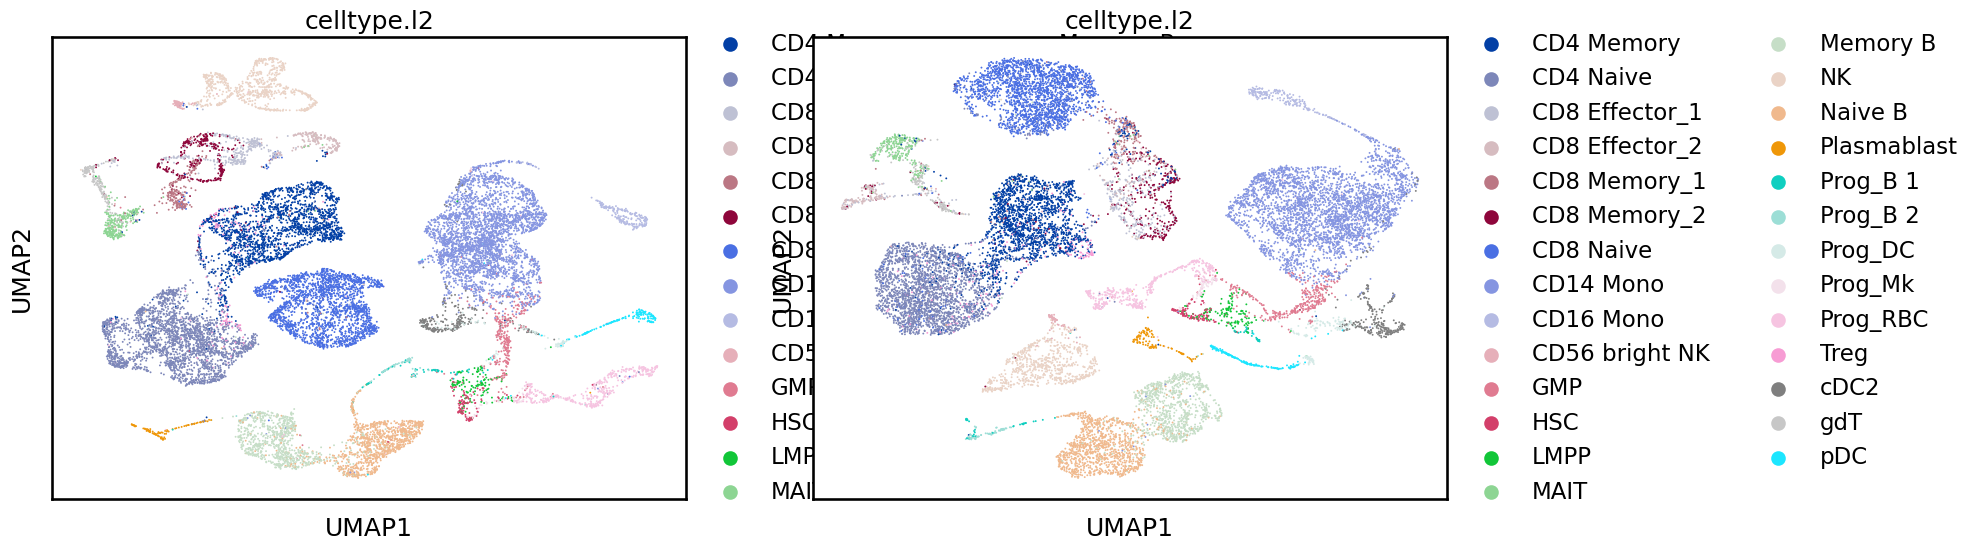

In [17]:
_, axes = plt.subplots(1, 2, figsize=(18, 6))

sc.pl.umap(ad_rna_imputed, color='celltype.l2', ax=axes[0], show=False)
sc.pl.umap(ad_adt_imputed, color='celltype.l2', ax=axes[1], show=False)